# Detecting bullying Tweets


In [9]:
!python -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.8.3) =================
ℹ spaCy installation: /usr/local/lib/python3.10/dist-packages/spacy

NAME             SPACY            VERSION                       
en_core_web_sm   >=3.7.2,<3.8.0   3.7.1   --> 3.8.0


============================== Install updates ==============================
Use the following commands to update the packages:
python -m spacy download en_core_web_sm



In [10]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
!pip install langdetect
!pip install contractions
!pip install emoji

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!ls '/content/drive/MyDrive/cyberbullying_tweets'

cyberbullying_tweets.csv


## Definición de funciones

In [14]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

## Import libraries

In [25]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
from emoji import replace_emoji
import nltk
import spacy
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
# from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("classic")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<Figure size 640x480 with 0 Axes>

## Importar Corpus

In [16]:
df = pd.read_csv('/content/drive/MyDrive/cyberbullying_tweets/cyberbullying_tweets.csv')

In [17]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [19]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Eliminar tweets duplicados


In [26]:
df.duplicated().sum()

0

In [27]:
df = df[~df.duplicated()]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Verificación de balanceo de datos


In [29]:
df.sentiment.value_counts()

,count
sentiment,
religion,7997
age,7992
ethnicity,7959
gender,7948
not_cyberbullying,7937
other_cyberbullying,7823


# Tweets text deep cleaning

In [31]:
# Cargar modelo SpaCy en inglés
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Función de preprocesamiento
def clean_tweet(tweet):
    # 1. Verificar si el texto está en inglés
    try:
        if detect(tweet) != "en":
            return ""
    except LangDetectException:
        return ""

    # 2. Expandir contracciones
    tweet = contractions.fix(tweet)

    # 3. Eliminar emojis
    tweet = replace_emoji(tweet, "")

    # 4. Eliminar enlaces, menciones, caracteres no ASCII y nueva línea
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)  # Enlaces y menciones
    tweet = re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', tweet)
    tweet = re.sub(r'[^\x00-\x7f]', '', tweet)  # No ASCII
    tweet = re.sub(r'\r|\n', ' ', tweet.lower())  # Nueva línea y minúsculas

    # 5. Eliminar hashtags al final y el símbolo # en el medio
    tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    tweet = re.sub(r'#([\w-]+)', r'\1', tweet)

    # 6. Filtrar caracteres especiales ($, &), puntuación y dígitos
    tweet = re.sub(r'\d+', '', tweet)  # Eliminar números
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    tweet = tweet.translate(table)

    # 7. Tokenizar y lematizar usando SpaCy
    doc = nlp(tweet)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) >= 2]

    # 8. Eliminar palabras repetidas o elongadas
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    tokens = [re.sub(regex_pattern, r'\1\3\4', word) for word in tokens]

    # 9. Reconstruir texto y eliminar espacios múltiples
    tweet = ' '.join(tokens)
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [32]:
# Aplicar limpieza al dataset
df['text_clean'] = df['text'].apply(clean_tweet)

In [33]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thank head concerned another angry dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretend kurdish account like isla...


### Cantidad de tweets duplicados después de la limpieza del texto.



In [34]:
# Eliminar tweets duplicados
print(f'Hay {int(df["text_clean"].duplicated().sum())} tweets duplicados.')
df.drop_duplicates("text_clean", inplace=True)

Hay 5370 tweets duplicados.


Se eliminarion tweets duplicados. Se mostrarán las clases para ver se hay problema con el balance de estos después de la limpieza.

In [35]:
df.sentiment.value_counts()

,count
sentiment,
religion,7910
age,7823
ethnicity,7384
gender,7349
not_cyberbullying,6496
other_cyberbullying,5324


### Eliminar la última categoría por perdida de datos

In [36]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [37]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [38]:
# Calcular la longitud del texto limpio
df['text_len'] = df['text_clean'].apply(lambda x: len(x.split()))

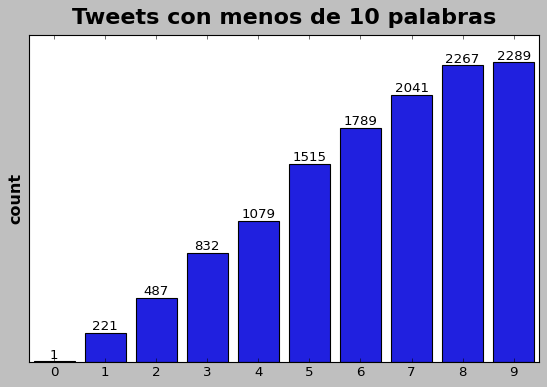

In [39]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10])
plt.title('Tweets con menos de 10 palabras', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [40]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white try live like nigger pahahahaha co...,174
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthis whore ...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullye program ...,137
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty kill feel guilty enjoy torment sin...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,117
...,...,...,...,...
4487,#EducateYourSelfNigga,not_cyberbullying,educateyourselfnigga,1
7182,@gee4672 @ZerrieIsReal I am really x,not_cyberbullying,really,1
4441,@a_man_in_black WHY AM I NOT ON THE LIST,not_cyberbullying,list,1
11489,ð¶ð¶ð¶ whaâ¦,gender,wha,1


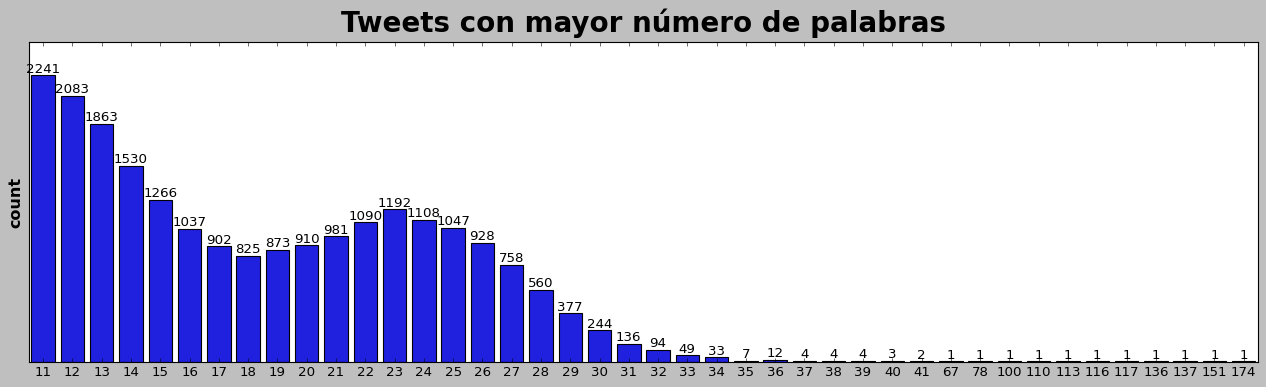

In [41]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)])
plt.title('Tweets con mayor número de palabras', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Eliminar twts con mayores a 100 palabras.

In [42]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [43]:
# Obtener longitud máxima de los tweets filtrados
max_len = np.max(df['text_len'])
print(f"Longitud máxima de tweets después de limpieza: {max_len}")

Longitud máxima de tweets después de limpieza: 31


In [44]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
37736,It honestly looks like a bunch of little pussi...,age,honestly look like bunch little pussy play arm...,31
38934,Someone needs to tell social media users how h...,age,someone need tell social medium user high scho...,31
40010,Welcome brother. We need opposition too. Anyth...,ethnicity,welcome brother need opposition anything build...,31
10290,i find it so odd that people r defending #jame...,gender,find odd people defend jamesgunn cuz past twee...,31
32735,Woke up with a heavy heart yaz I'm thinking ab...,age,wake heavy heart yaz think get bully high scho...,31
...,...,...,...,...
1316,@shinynhappy grosssssss,not_cyberbullying,grosssss,1
4441,@a_man_in_black WHY AM I NOT ON THE LIST,not_cyberbullying,list,1
14298,@DazzyTheMermaid @Bbrad5150 ...to racists.,gender,racist,1
160,ITS BEAUTIFULLLLLLL :'( :'( :'( :'(,not_cyberbullying,beautifulllll,1


## Columna de sentimiento


In [45]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

<ipython-input-45-5cd3204e082e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


## Train - Test split

In [46]:
# Dividir los datos
X = df['text_clean'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
# Vectorización TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [58]:
# Aplicar SMOTE para balanceo de clases después de la vectorización
smote = SMOTE(random_state=seed_value)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


## Entrenar Modelo con Naive Bayes

In [59]:
# Entrenar el modelo Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [60]:
# Predecir
nb_pred = nb_clf.predict(X_test_tf)

In [61]:
# Reporte de clasificación
print('Classification Report for Naive Bayes:\n', classification_report(y_test, nb_pred, target_names=['religion', 'age', 'ethnicity', 'gender', 'not_cyberbullying']))

Classification Report for Naive Bayes:
                    precision    recall  f1-score   support

         religion       0.85      0.96      0.90      1567
              age       0.89      0.96      0.92      1555
        ethnicity       0.93      0.91      0.92      1467
           gender       0.91      0.80      0.85      1461
not_cyberbullying       0.70      0.63      0.67      1298

         accuracy                           0.86      7348
        macro avg       0.86      0.85      0.85      7348
     weighted avg       0.86      0.86      0.86      7348



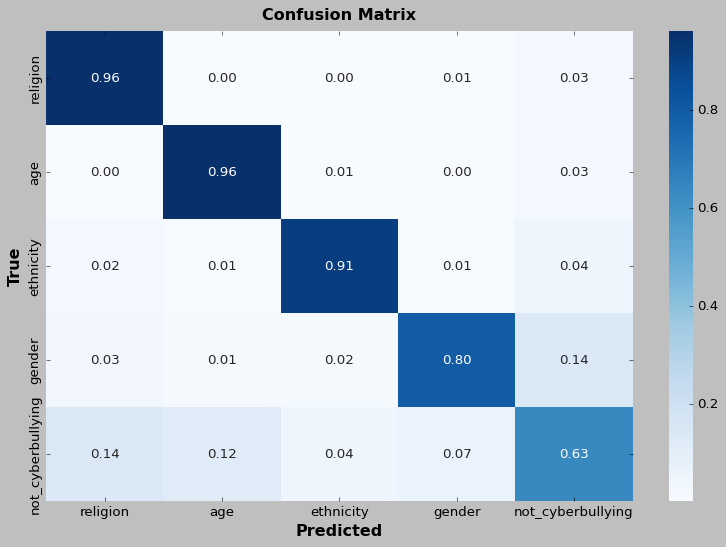

In [62]:
# Matriz de confusión
conf_mat = confusion_matrix(y_test, nb_pred, normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=['religion', 'age', 'ethnicity', 'gender', 'not_cyberbullying'], yticklabels=['religion', 'age', 'ethnicity', 'gender', 'not_cyberbullying'], cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

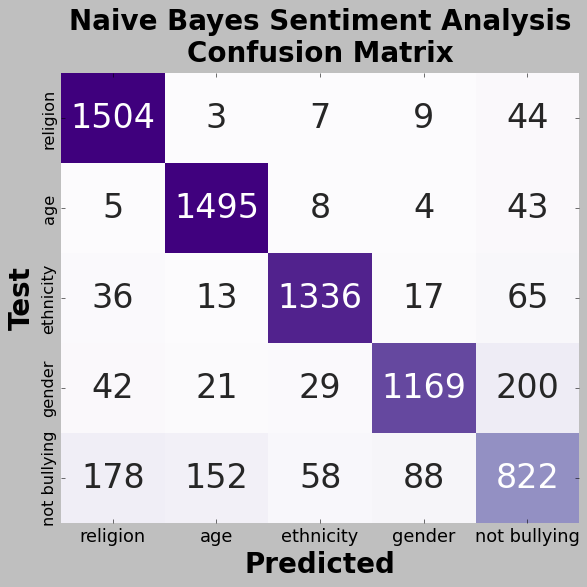

In [63]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

# BERT Classification

En este sección se usa el modelo pre entrenado BERT de Hugging Face.

In [66]:
!pip install transformers

In [68]:
from transformers import get_linear_schedule_with_warmup

In [69]:
X = df['text_clean'].values
y = df['sentiment'].values

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [72]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [73]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [74]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

# Tokenización con BERT

In [81]:
# Configuración de parámetros
MAX_LEN = 128
batch_size = 32
EPOCHS = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
# Tokenizer y modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [83]:
# Tokenización y creación de entradas para el modelo
def bert_tokenizer(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',  # 'padding' en vez de 'pad_to_max_length'
            truncation=True,        # Truncar texto que exceda el max_length
            return_attention_mask=True
        )
        input_ids.append(encoded_sent['input_ids'])
        attention_masks.append(encoded_sent['attention_mask'])

    return torch.tensor(input_ids), torch.tensor(attention_masks)


In [84]:
# Preparación de los datos
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

In [85]:
# Convertir las etiquetas a tensores
train_labels = torch.tensor(y_train_os)
val_labels = torch.tensor(y_valid)
test_labels = torch.tensor(y_test)

In [86]:
# DataLoader para entrenamiento, validación y prueba
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [87]:
# Definir el modelo BERT con capa de clasificación
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(768, 50),
            nn.ReLU(),
            nn.Dropout(0.3),  # Agregar Dropout para evitar sobreajuste
            nn.Linear(50, 5)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

# Inicializar el modelo, optimizador y scheduler
def initialize_model(epochs=4):
    model = Bert_Classifier(freeze_bert=False)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return model, optimizer, scheduler

In [89]:
# Función de entrenamiento
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, b_labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {total_train_loss / len(train_dataloader)}')

        # Evaluación en el conjunto de validación
        model.eval()
        total_eval_loss = 0
        preds, true_labels = [], []

        for batch in val_dataloader:
            b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                outputs = model(b_input_ids, b_attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, b_labels)
                total_eval_loss += loss.item()

            preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels.append(b_labels.cpu().numpy())

        print(f'Validation Loss: {total_eval_loss / len(val_dataloader)}')

        # Calcular la métrica F1
        preds = np.concatenate(preds)
        true_labels = np.concatenate(true_labels)
        print(classification_report(true_labels, preds, target_names=sentiments))


In [90]:
# Entrenar el modelo
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)
train(bert_classifier, train_dataloader, val_dataloader, optimizer, scheduler, epochs=EPOCHS)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Training Loss: 0.3264947801030108
Validation Loss: 0.20224487580075537
              precision    recall  f1-score   support

    religion       0.96      0.95      0.96      1254
         age       0.97      0.98      0.98      1244
   ethnicity       0.98      0.98      0.98      1173
      gender       0.93      0.86      0.89      1169
not bullying       0.79      0.87      0.83      1039

    accuracy                           0.93      5879
   macro avg       0.93      0.93      0.93      5879
weighted avg       0.93      0.93      0.93      5879

Epoch 2/4, Training Loss: 0.17236220592167228
Validation Loss: 0.20622131323097678
              precision    recall  f1-score   support

    religion       0.95      0.97      0.96      1254
         age       0.97      0.99      0.98      1244
   ethnicity       0.97      0.99      0.98      1173
      gender       0.95      0.86      0.90      1169
not bullying       0.82      0.86      0.84      1039

    accuracy        

In [91]:
# Predicción con el modelo entrenado
def predict(model, test_dataloader):
    model.eval()
    preds_list = []

    for batch in test_dataloader:
        b_input_ids, b_attention_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logit = model(b_input_ids, b_attention_mask)

        pred = torch.argmax(logit, dim=1).cpu().numpy()
        preds_list.extend(pred)

    return preds_list

# Realizar la predicción
bert_preds = predict(bert_classifier, test_dataloader)
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.95      0.96      0.96      1567
         age       0.99      0.98      0.98      1555
   ethnicity       0.99      0.99      0.99      1467
      gender       0.92      0.89      0.90      1461
not bullying       0.83      0.85      0.84      1298

    accuracy                           0.94      7348
   macro avg       0.93      0.93      0.93      7348
weighted avg       0.94      0.94      0.94      7348



In [92]:
# Guardar el modelo (pesos y arquitectura)
def save_model(model, tokenizer, model_path="bullying_tweets_model.pth", tokenizer_path="tokenizer"):
    # Guardar pesos del modelo
    torch.save(model.state_dict(), model_path)
    print(f"Modelo guardado en {model_path}")

    # Guardar el tokenizador
    tokenizer.save_pretrained(tokenizer_path)
    print(f"Tokenizador guardado en {tokenizer_path}")

# Llamar a la función para guardar el modelo y tokenizador
save_model(bert_classifier, tokenizer)


Modelo guardado en bullying_tweets_model.pth
Tokenizador guardado en tokenizer


Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.95      0.96      0.96      1567
         age       0.99      0.98      0.98      1555
   ethnicity       0.99      0.99      0.99      1467
      gender       0.92      0.89      0.90      1461
not bullying       0.83      0.85      0.84      1298

    accuracy                           0.94      7348
   macro avg       0.93      0.93      0.93      7348
weighted avg       0.94      0.94      0.94      7348



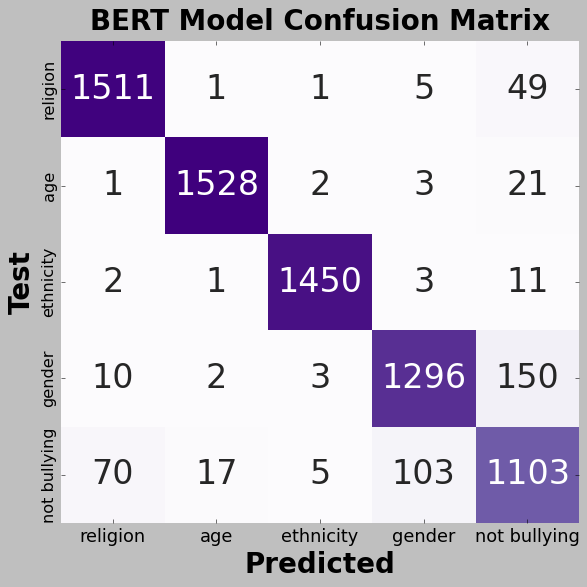

In [96]:
# Usar la función para imprimir la matriz de confusión
bert_preds = bert_predict(bert_classifier, test_dataloader)
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))
conf_matrix(y_test, bert_preds, 'BERT Model Confusion Matrix', sentiments)